<a href="https://colab.research.google.com/github/HedayatHaddadi/HedayatHaddadi/blob/main/Latest_AC_ChemProp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [154]:
!pip install chemprop
!pip install rdkit-pypi  # should be included in above after Chemprop v1.6 release
!pip install gdown  # For downloading files from Google Drive

import chemprop
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
import gdown

In [158]:
def plot_parity(y_true, y_pred, y_pred_unc=None):
    axmin = min(min(y_true), min(y_pred)) - 0.1*(max(y_true)-min(y_true))
    axmax = max(max(y_true), max(y_pred)) + 0.1*(max(y_true)-min(y_true))

    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)

    plt.plot([axmin, axmax], [axmin, axmax], '--k')

    plt.errorbar(y_true, y_pred, yerr=y_pred_unc, linewidth=0, marker='o', markeredgecolor='w', alpha=1, elinewidth=1)

    plt.xlim((axmin, axmax))
    plt.ylim((axmin, axmax))

    ax = plt.gca()
    ax.set_aspect('equal')

    at = AnchoredText(
    f"MAE = {mae:.2f}\nRMSE = {rmse:.2f}", prop=dict(size=10), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

    plt.xlabel('True')
    plt.ylabel('Chemprop Predicted')

    plt.show()

    return

In [159]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the paths to the datasets
#  These datasets have been preprocessed to remove outliers.
train_file_path = '/content/drive/My Drive/Colab Notebooks/Test Code/Train_Val_IL_Filt.csv'
test_file_path = '/content/drive/My Drive/Colab Notebooks/Test Code/Test_IL_Filt.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [160]:
# Load training data
ac_df_train = pd.read_csv(train_file_path)
print("Training Data Loaded:")
print(ac_df_train.head())


Training Data Loaded:
   index  cation_id Cation of IL  anion_id Anion of IL  IL_id  \
0      0          0      DABCO-6        17        NTF2      0   
1      1          0      DABCO-6        17        NTF2      0   
2      2          0      DABCO-6        17        NTF2      0   
3      3          0      DABCO-6        17        NTF2      0   
4      4          0      DABCO-6        17        NTF2      0   

               IL_x  cationic_family_id Cationic family of IL  solute_id  ...  \
0  [DABCO-6]_[NTF2]                   1              bicyclic         52  ...   
1  [DABCO-6]_[NTF2]                   1              bicyclic         52  ...   
2  [DABCO-6]_[NTF2]                   1              bicyclic         52  ...   
3  [DABCO-6]_[NTF2]                   1              bicyclic         52  ...   
4  [DABCO-6]_[NTF2]                   1              bicyclic         52  ...   

               IL_y                                          SMILES_IL  \
0  [DABCO-6]_[NTF2]  CCCCC

In [161]:


# Since the free GPUs on Google Colab cannot accommodate a dataset of this size (approximately 40,000 rows),
# I have decided to reduce the dataset by randomly selecting a subset of rows from ac_df_train to evaluate the functionality of the code.
# We need to evaluate the model on the entire dataset by upgrading the hardware, particularly by increasing the number of GPUs.
ac_df_train = ac_df_train.sample(frac=0.05, random_state=42)



# Normalize temperature feature
ac_df_train['T/K'] = (ac_df_train['T/K'] - ac_df_train['T/K'].min()) / (ac_df_train['T/K'].max() - ac_df_train['T/K'].min())

# Save temperature features with a header
train_features = ac_df_train[['T/K']]
train_features.to_csv('train_features.csv', index=False, header=True)  # Save with a header

# Save SMILES and target columns with header
ac_df_train[['SMILES_IL', 'SMILES_solute', 'IDAC (exptl)']].to_csv('Train_Val_IL.csv', index=False)

In [162]:
# Training with temperature included as a feature
arguments = [
    '--data_path', 'Train_Val_IL.csv',
    '--dataset_type', 'regression',
    '--save_dir', 'test_checkpoints_multimolecule',
    '--epochs', '5',
    '--save_smiles_splits',
    '--number_of_molecules', '2',
    '--smiles_columns', 'SMILES_IL', 'SMILES_solute',  # SMILES columns
    '--target_columns', 'IDAC (exptl)',  # target column
    '--features_path', 'train_features.csv',  # Path to temperature feature file with header
]

args = chemprop.args.TrainArgs().parse_args(arguments)
mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)

Command line
python /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-c5eceb52-09ce-458d-94b1-83ba7a04ce9d.json
Args
{'activation': 'ReLU',
 'adding_bond_types': True,
 'adding_h': False,
 'aggregation': 'mean',
 'aggregation_norm': 100,
 'atom_constraints': [],
 'atom_descriptor_scaling': True,
 'atom_descriptors': None,
 'atom_descriptors_path': None,
 'atom_descriptors_size': 0,
 'atom_features_size': 0,
 'atom_messages': False,
 'atom_targets': [],
 'batch_size': 50,
 'bias': False,
 'bias_solvent': False,
 'bond_constraints': [],
 'bond_descriptor_scaling': True,
 'bond_descriptors': None,
 'bond_descriptors_path': None,
 'bond_descriptors_size': 0,
 'bond_features_size': 0,
 'bond_targets': [],
 'cache_cutoff': 10000,
 'checkpoint_dir': None,
 'checkpoint_frzn': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'class_balance': False,
 'config_path': None,
 'constraints_path': None,
 'crossval_index_dir': None,

In [163]:
# Load test data
ac_df_test = pd.read_csv(test_file_path)
print("Test Data Loaded:")
print(ac_df_test.head())


# Normalize temperature feature
ac_df_test['T/K'] = (ac_df_test['T/K'] - ac_df_test['T/K'].min()) / (ac_df_test['T/K'].max() - ac_df_test['T/K'].min())

# Save test temperature features with a header 'T/K'
test_features = ac_df_test[['T/K']]
test_features.to_csv('test_features.csv', index=False, header=['T/K'])  # Added header 'T/K'

# Save SMILES and target columns for test data with a header
ac_df_test[['SMILES_IL', 'SMILES_solute', 'IDAC (exptl)']].to_csv('Test_IL.csv', index=False)  # Save SMILES and target


Test Data Loaded:
   index  cation_id Cation of IL  anion_id Anion of IL  IL_id  \
0      5          0      DABCO-6        17        NTF2      0   
1      6          0      DABCO-6        17        NTF2      0   
2      7          0      DABCO-6        17        NTF2      0   
3      8          0      DABCO-6        17        NTF2      0   
4      9          0      DABCO-6        17        NTF2      0   

               IL_x  cationic_family_id Cationic family of IL  solute_id  ...  \
0  [DABCO-6]_[NTF2]                   1              bicyclic         34  ...   
1  [DABCO-6]_[NTF2]                   1              bicyclic         34  ...   
2  [DABCO-6]_[NTF2]                   1              bicyclic         34  ...   
3  [DABCO-6]_[NTF2]                   1              bicyclic         61  ...   
4  [DABCO-6]_[NTF2]                   1              bicyclic         61  ...   

               IL_y                                          SMILES_IL  \
0  [DABCO-6]_[NTF2]  CCCCCC[N+

In [164]:
# drive.mount('/content/drive')
# test_file_path = '/content/drive/My Drive/Colab Notebooks/Test Code/Test_IL.csv'

# Predicting with the temperature feature
arguments = [
    '--test_path', test_file_path,  # Use the actual variable, not a string
    '--preds_path', 'test_preds_multimolecule.csv',
    '--checkpoint_dir', 'test_checkpoints_multimolecule',
    '--number_of_molecules', '2',
    '--features_path', 'test_features.csv',  # Ensure the path to test temperature feature file is correct
]

args = chemprop.args.PredictArgs().parse_args(arguments)
test_preds = chemprop.train.make_predictions(args=args)


Loading training args


/usr/local/lib/python3.10/dist-packages/chemprop/utils.py:473: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vars(torch.load(path, map_location=lambda storage, loc: storage)

Setting molecule featurization parameters to default.
Loading data


3554it [00:00, 47585.56it/s]
100%|██████████| 3554/3554 [00:00<00:00, 44109.28it/s]

Validating SMILES



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test size = 0
Elapsed time = 0:00:01


In [165]:
# Predicting with the temperature feature
arguments = [
    '--test_path', 'Test_IL.csv',
    '--preds_path', 'test_preds_multimolecule.csv',
    '--checkpoint_dir', 'test_checkpoints_multimolecule',
    '--number_of_molecules', '2',
    '--features_path', 'test_features.csv',  # Path to test temperature feature file with header 'T/K'
]

args = chemprop.args.PredictArgs().parse_args(arguments)
test_preds = chemprop.train.make_predictions(args=args)

print(test_preds)


Loading training args
Setting molecule featurization parameters to default.
Loading data


3554it [00:00, 87599.57it/s]
100%|██████████| 3554/3554 [00:00<00:00, 8520.95it/s]


Validating SMILES
Test size = 3,554


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/chemprop/utils.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path, ma

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "encoder.encoder.1.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.1.W_i.weight".
Loading pretrained parameter "encoder.encoder.1.W_h.weight".
Loading pretrained parameter "encoder.encoder.1.W_o.weight".
Loading pretrained parameter "encoder.encoder.1.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".



100%|██████████| 1/1 [00:12<00:00, 12.35s/it]

Saving predictions to test_preds_multimolecule.csv
Elapsed time = 0:00:13
[[2.016886995848512], [1.9867315792841245], [1.957469408712234], [2.072448632572301], [2.0447209197362857], [2.013283395319769], [1.9413783554622261], [2.0264933357006893], [2.0833006244772663], [0.7635321956392369], [2.1651494176025263], [1.9581262443696148], [0.7943987370167331], [0.8222168791731903], [1.9837867082205194], [0.841445024974234], [0.9016406514644015], [0.9903844830017139], [2.1890936181727936], [2.1761028860398555], [2.194889616815985], [2.2317527426417016], [2.2710315780799903], [2.320830042161725], [13.529236724989847], [13.86628589817164], [14.123798301865996], [14.349505466804171], [14.557523836013882], [14.73625699332398], [14.733502134305425], [14.959085570470076], [15.169330426333882], [15.355772012488071], [2.568031293883324], [2.600955930841767], [2.648008847126421], [2.7104238584915867], [4.161313105434231], [4.1167940250210515], [4.170519536214855], [4.216464298780814], [5.9048175086772

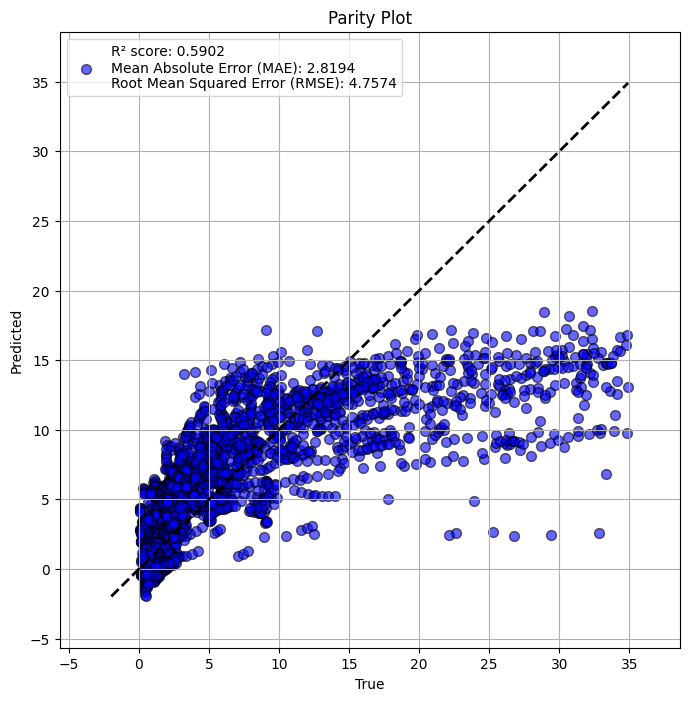

In [166]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def plot_parity(y_true, y_pred,
                title='Parity Plot',
                xlabel='True',
                ylabel='Predicted',
                color='blue',
                save_path=None):
    """
    Create a parity plot comparing true values and predicted values.

    Parameters:
    - y_true: array-like, true target values
    - y_pred: array-like, predicted target values
    - title: str, title of the plot
    - xlabel: str, label for the x-axis
    - ylabel: str, label for the y-axis
    - color: str, color of the scatter points
    - save_path: str or None, if provided, saves the plot to this path
    """
    # Create a figure
    plt.figure(figsize=(8, 8))

    # Scatter plot
    plt.scatter(y_true, y_pred, color=color, alpha=0.6, edgecolors='k', s=50)

    # Set limits based on data range with padding
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    padding = 0.1 * (max_val - min_val)
    plt.xlim(min_val - padding, max_val + padding)
    plt.ylim(min_val - padding, max_val + padding)

    # Diagonal line for reference
    plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=2)

    # Add labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Calculate metrics
    metrics = {
        'R² score': r2_score(y_true, y_pred),
        'Mean Absolute Error (MAE)': mean_absolute_error(y_true, y_pred),
        'Root Mean Squared Error (RMSE)': np.sqrt(mean_squared_error(y_true, y_pred))
    }

    # Add a legend box with the metrics
    metrics_report = '\n'.join([f'{k}: {v:.4f}' for k, v in metrics.items()])
    plt.legend([metrics_report], loc='upper left', frameon=True)

    # Add grid
    plt.grid()

    # Show or save the plot
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f'Plot saved to {save_path}')
    else:
        plt.show()

# Usage
ac_df_test['IDAC pred'] = [x[0] for x in test_preds]  # Ensure predictions are merged
plot_parity(ac_df_test['IDAC (exptl)'], ac_df_test['IDAC pred'])
